In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("IMDB").getOrCreate()

Now i am working on a dataset with size over 700 mb 
I will be using PySpark to get insightful statistics that would help in the process of analysis and visulaization of data.  
Gathering the info about how many ratings does every movie has and the average rating of every movie, also the users rate of ratings in value and also quantity.

In [3]:
df_pyspark = spark.read.csv("data/ratings.csv", header=True)
df_pyspark.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
|     1|   1246|   5.0|1425941556|
+------+-------+------+----------+
only showing top 5 rows



In [4]:
# drop timestamp since we don't need it
df_pyspark = df_pyspark.drop("timestamp")

##### We have over 26 million reviews !!! 
##### over 45k unique movie with over 250k unique user

In [5]:
print(df_pyspark.count())
print(df_pyspark.select('movieId').distinct().count())
print(df_pyspark.select('userId').distinct().count())

26024289
45115
270896


In [5]:
df_pyspark.groupBy('movieId').agg(F.mean('rating'), F.count('rating')).sort('count(rating)', ascending=False).show(5)


+-------+-----------------+-------------+
|movieId|      avg(rating)|count(rating)|
+-------+-----------------+-------------+
|    356|4.052925882007376|        91921|
|    318|4.429014514393623|        91082|
|    296|4.169975313136369|        87901|
|    593| 4.15224553390899|        84078|
|   2571|4.154098255515649|        77960|
+-------+-----------------+-------------+
only showing top 5 rows



In [9]:
movies_rating = df_pyspark.groupBy('movieId').agg(F.mean('rating'), F.count('rating')).sort('count(rating)', ascending=False).toPandas()


array([[<Axes: title={'center': 'avg(rating)'}>]], dtype=object)

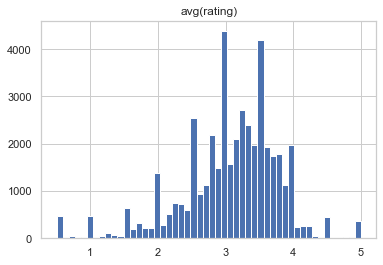

In [15]:
movies_rating.hist(column='avg(rating)', bins=50)


Movie with id 356 is not found????

In [32]:
movies = pd.read_csv("processed/metadata.csv")
#get movie with id 356
movies[movies['movie_id'] == '356']

,movie_id,title,release_date,popularity,budget,revenue,vote_average,vote_count


In [16]:
df_pyspark.groupBy('userId').agg(F.mean('rating'), F.count('rating')).show(5)

+------+------------------+-------------+
|userId|       avg(rating)|count(rating)|
+------+------------------+-------------+
|   296|3.5853658536585367|          123|
|   467|               4.2|            5|
|   675| 3.227272727272727|           22|
|   691|3.8947368421052633|           19|
|   829|3.7196969696969697|          132|
+------+------------------+-------------+
only showing top 5 rows



In [17]:
user_ratings = df_pyspark.groupBy('userId').agg(F.mean('rating'), F.count('rating')).toPandas()

array([[<Axes: title={'center': 'avg(rating)'}>]], dtype=object)

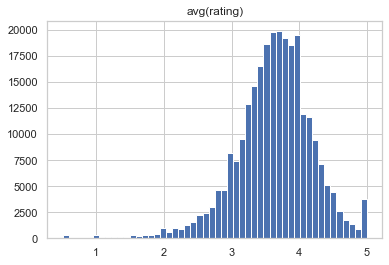

In [18]:
user_ratings.hist(column='avg(rating)', bins=50)

In [34]:
movies_ratings = df_pyspark.groupBy('movieId').agg(F.mean('rating'), F.count('rating')).toPandas()
users_ratings = df_pyspark.groupBy('userId').agg(F.mean('rating'), F.count('rating')).toPandas()

movies_ratings.columns = ['movieId', 'rating_avg', 'rating_count']
users_ratings.columns = ['userId', 'rating_avg', 'rating_count']

#save to csv
movies_ratings.to_csv("processed/movies_ratings.csv", index=False)
users_ratings.to_csv("processed/users_ratings.csv", index=False)

since some of the data in rating were not found in the movies we will validate them

# Data integrity 

In [35]:
meta_data = pd.read_csv("processed/metadata.csv")
movie_ratings = pd.read_csv("processed/movies_ratings.csv")

In [36]:
# First check the movies ids to be the same in both
meta_id = set(meta_data.movie_id.unique())
ratings_id = set(movie_ratings.movieId.unique())
meta_id == ratings_id

False

In [37]:
len(meta_id), len(ratings_id)

(44985, 45115)

In [38]:
print(f"The number of movies only in the metadata {len(meta_id - ratings_id)}")
print(f"The number of movies only in the ratings {len(ratings_id - meta_id)}")
print(f"The number of movies only in both {len(ratings_id & meta_id)}")

The number of movies only in the metadata 37482
The number of movies only in the ratings 37612
The number of movies only in both 7503


After investegation, the ids of interest are the nearly 7.5k movies that we have metadata about and are actually rated by users, this requires refining the cleaned data to ensure integrity, to explore the content based and user based recommendation, the data should appear in both

In [39]:
target_ids = ratings_id & meta_id

In [40]:
# Filter the metadata
# We will filter the metadata to only include the movies that are in the ratings dataset
# we will also drop duplicates
simple_filters_files = ['actors', 'directors', 'genres', 'keywords', 'metadata']

for filename in simple_filters_files:
    df = pd.read_csv(f'./processed/{filename}.csv')
    df.movie_id = df.movie_id.astype(int)
    df = df[df.movie_id.isin(target_ids)]
    df.drop_duplicates(inplace= True)
    df.to_csv(f'./dataclean/{filename}.csv', header= True, index= False)
    
    

In [41]:
# second we should filter the ratings before applying aggregate functions again
ratings = pd.read_csv(r'./data/ratings.csv')
ratings.shape


(26024289, 4)

In [42]:
# timestamp is still not needed
ratings.drop(columns= ['timestamp'], inplace= True)

In [43]:
ratings = ratings[ratings.movieId.isin(target_ids)]
len(ratings)

11417356

We are left with legit 11 Million ratings for the 7500 movies 

In [44]:
ratings.to_csv('./dataclean/ratings.csv', header= True, index= False)

In [45]:
df_pyspark = spark.read.csv(r'./dataclean/ratings.csv', header= True, inferSchema= True)
df_pyspark.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    110|   1.0|
|     1|    147|   4.5|
|     1|    858|   5.0|
|     1|   1246|   5.0|
|     1|   1968|   4.0|
+------+-------+------+
only showing top 5 rows



In [46]:

movies_ratings = df_pyspark.groupBy('movieId').agg(F.mean('rating'), F.count('rating')).toPandas()
users_ratings = df_pyspark.groupBy('userId').agg(F.mean('rating'), F.count('rating')).toPandas()

movies_ratings.columns = ['movieId', 'rating_avg', 'rating_count']
users_ratings.columns = ['userId', 'rating_avg', 'rating_count']

#round to 2 decimals
movies_ratings.rating_avg = movies_ratings.rating_avg.round(2)
users_ratings.rating_avg = users_ratings.rating_avg.round(2)

#save to csv
movies_ratings.to_csv("./dataclean/movies_ratings.csv", index=False)
users_ratings.to_csv("./dataclean/users_ratings.csv", index=False)